ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

In [680]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats

# для всех статистических тестов зададим уровень значимости альфа = 0.05 

In [681]:
data=pd.read_csv('data\ds_salaries.csv', index_col='Unnamed: 0')

1. ОЧИСТКА ДАННЫХ

In [682]:
data.duplicated().value_counts()  # 42
data.drop_duplicates(inplace=True)
data.info() # пропуски отсутствуют, формат верный

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary              565 non-null    int64 
 5   salary_currency     565 non-null    object
 6   salary_in_usd       565 non-null    int64 
 7   employee_residence  565 non-null    object
 8   remote_ratio        565 non-null    int64 
 9   company_location    565 non-null    object
 10  company_size        565 non-null    object
dtypes: int64(4), object(7)
memory usage: 53.0+ KB


In [683]:
data.head(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


1.1 Целевые признаки

In [684]:
data['job_title'].value_counts()

# представлено достаточно большое количество разных названий рабочей роли
# в настоящем проекте целевыми ролями являются Data Scientist и Data Engineer (их большинство), таким образом, иные рабочие роли нам не пригодятся

# стоит отметить, что есть рабочие роли типа: Data Science Engineer, Big Data Engineer и т.д., которые можно отнести к Data Scientist и Data Engineer
# иначе говоря, при должном воображении, каждую из представленных рабочих ролей можно отнести к целевым 
# мы остановимся исключительно на дословных описаниях рабочих ролей

data=data[(data['job_title']=='Data Scientist')|(data['job_title']=='Data Engineer')]

1.2 Страны

In [685]:
# посмотрим на совпадение страны сотрудника и работодателя
data['country_coincidence']=data['employee_residence']==data['company_location']
data['country_coincidence'].value_counts() # различия в 18 случаях из 251 (можно было признак и не создавать)

# удалим строки с различающимися странами ввиду их малого количества
data=data[data['country_coincidence']==True]

# посмотрим на страны вообще
data['employee_residence'].value_counts() 
data['company_location'].value_counts()
# большое количество разных стран проживания сотрудников и стран работодателя, где преобладает US

# т.к. теперь страны у нас совпадают, оставим один из признаков employee_residence и company_location
data.drop(columns=['employee_residence','country_coincidence'], inplace=True) 
data.rename(columns={'company_location':'country'}, inplace=True)

# также поделим названия стран на US и other
def country_code(arg):
    if ('US' in arg):
        return 'US'
    else:
        return 'other'

data['country']=data['country'].apply(country_code)

1.3 Заработная плата

In [686]:
# признаки salary, salary_currency, salary_in_usd напрямую связаны (не проверял, принимаю на веру)
# оставим признак salary_in_usd

data.drop(columns=['salary_currency','salary'], inplace=True) 

Text(0.5, 1.0, 'Распределение зарплат у DS и DE')

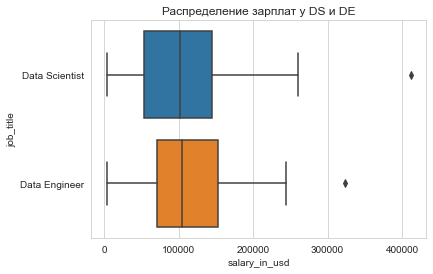

In [687]:
# оценим наличие выбросов с помощью коробчатой диаграммы, заодно сможем увидеть медианную зарплату на всем множестве 

fig1 = sns.boxplot(y=data['job_title'], x=data['salary_in_usd'], orient='h')
fig1.set_title('Распределение зарплат у DS и DE')

In [688]:
data=data[data['salary_in_usd']<300000] # избавимся от двух значений зарплаты, которые резко выделяются на фоне остальных

1.4 Остальные признаки

In [689]:
# Принцип отбора заключается в оценке количества каждой вариации признака на фоне его разнообразия... 

In [690]:
data['work_year'].value_counts() # все оставляем 

2022    138
2021     67
2020     26
Name: work_year, dtype: int64

In [691]:
data['experience_level'].value_counts() # EX удаляем  

SE    99
MI    98
EN    31
EX     3
Name: experience_level, dtype: int64

In [692]:
data['employment_type'].value_counts() # PT удаляем

FT    227
PT      4
Name: employment_type, dtype: int64

In [693]:
data['remote_ratio'].value_counts() # все оставляем 

100    136
0       63
50      32
Name: remote_ratio, dtype: int64

In [694]:
data['company_size'].value_counts() # все оставляем 

M    140
L     71
S     20
Name: company_size, dtype: int64

In [695]:
data=data[(data['experience_level']!='EX')&(data['employment_type']!='PT')] # удаляем

In [696]:
# очистка данных так далеко зашла, что признак employment_type стал похож на тождество
data.drop(columns='employment_type', inplace=True)

2. Первичная визуализация признаков (на всякий случай)

In [697]:
data

,work_year,experience_level,job_title,salary_in_usd,remote_ratio,country,company_size
0,2020,MI,Data Scientist,79833,0,other,L
7,2020,MI,Data Scientist,35735,50,other,L
10,2020,EN,Data Scientist,51321,0,other,S
11,2020,MI,Data Scientist,40481,0,other,L
12,2020,EN,Data Scientist,39916,0,other,M
...,...,...,...,...,...,...,...
593,2022,SE,Data Scientist,150000,100,US,M
598,2022,MI,Data Scientist,160000,100,US,M
599,2022,MI,Data Scientist,130000,100,US,M
602,2022,SE,Data Engineer,154000,100,US,M


2.1 Зарплата

Text(0.5, 1.0, 'Общее распределение зарплаты')

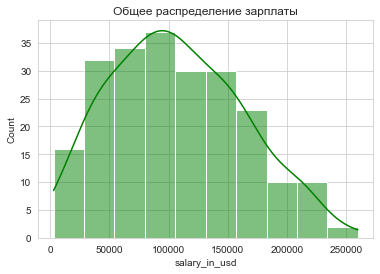

In [698]:
fig2= sns.histplot(x=data['salary_in_usd'], color='green', kde=True) # похоже на нормальное распределение
fig2.set_title('Общее распределение зарплаты')

2.2 Год выплаты

In [699]:
# здесь и далее для категориальных признаков представлены гистограммы, которые фактически представляют собой столбчатые диаграммы 
# с вариациями признака по оси X и их количеством по оси Y

Text(0.5, 1.0, 'Распределение годов выплат')

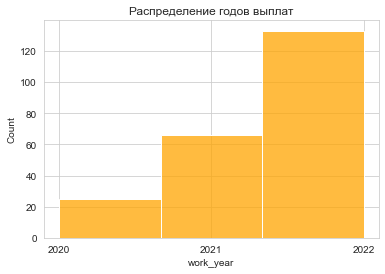

In [700]:
fig3 = sns.histplot(x=data['work_year'], bins=3, color='orange')
plt.xticks([2020, 2021, 2022])
fig3.set_title('Распределение годов выплат')

2.3 Опыт работы

Text(0.5, 1.0, 'Распределение опыта работы')

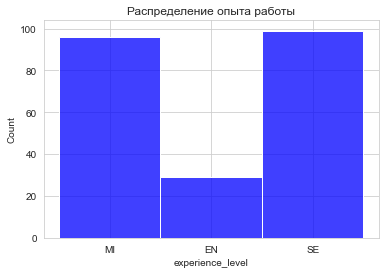

In [701]:
fig4 = sns.histplot(x=data['experience_level'], color='blue')
fig4.set_title('Распределение опыта работы')

2.4 Рабочая роль 

Text(0.5, 1.0, 'Распределение рабочих ролей')

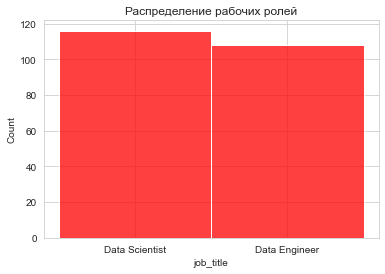

In [702]:
fig5 = sns.histplot(x=data['job_title'], color='red')
fig5.set_title('Распределение рабочих ролей')

2.5 Общий объём работы, выполняемой удалённо

Text(0.5, 1.0, 'Распределение объема работы')

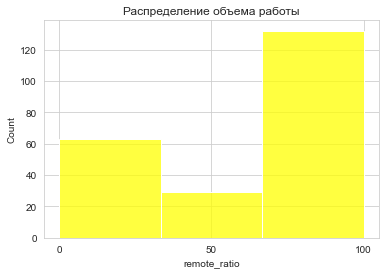

In [703]:
fig6 = sns.histplot(x=data['remote_ratio'], bins=3, color='yellow')
plt.xticks([0, 50, 100])
fig6.set_title('Распределение объема работы')

2.6 Страна

Text(0.5, 1.0, 'Распределение работодателей (работников) по странам ')

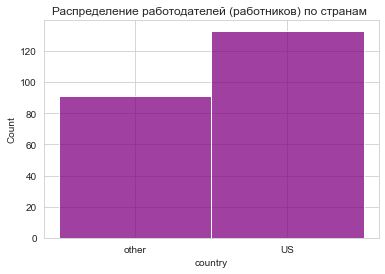

In [704]:
fig7= sns.histplot(x=data['country'], color='purple')
fig7.set_title('Распределение работодателей (работников) по странам ')

2.7 Размер компании

Text(0.5, 1.0, 'Распределение размеров компаний')

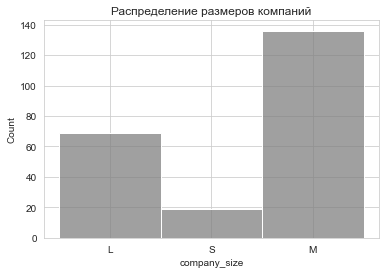

In [705]:
fig8 = sns.histplot(x=data['company_size'], color='grey')
fig8.set_title('Распределение размеров компаний')

3. Ключевые вопросы

In [706]:
# для удобства разделим данные на отдельные таблицы
data_ds=data[data['job_title']=='Data Scientist']
data_de=data[data['job_title']=='Data Engineer']

3.1 Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Text(0.5, 1.0, 'Зависимость средней зарплаты DS по годам')

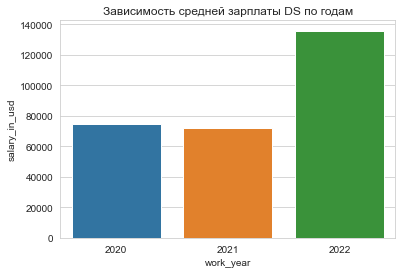

In [707]:
df311=data_ds.groupby(by='work_year', as_index=False)['salary_in_usd'].mean() 
# т.к. мы избавились от выбросов в размере зарплаты (см. п. 1.3) можем использовать среднее, а не медиану

fig9=sns.barplot(data=df311, x='work_year', y='salary_in_usd') 
fig9.set_title('Зависимость средней зарплаты DS по годам')

По графику видно, что средняя зарплата у DS растет, но не из года в год. Проверим 2020 г. и 2021 г. на предмет "погрешности" с помощью статистического теста.

In [708]:
data_ds['salary_in_usd'][data_ds['work_year']==2020].mean() # 74675
data_ds['salary_in_usd'][data_ds['work_year']==2021].mean() # 71944
data_ds['salary_in_usd'][data_ds['work_year']==2022].mean() # 135848

sal_2020=data_ds['salary_in_usd'][data_ds['work_year']==2020].to_list()
sal_2021=data_ds['salary_in_usd'][data_ds['work_year']==2021].to_list()
print('зарплаты в 2020 г.', sal_2020)
print('зарплаты в 2021 г.', sal_2021)

# проводим тест Шапиро — Уилка
print('зарплата в 2020 г. p-value:', stats.shapiro(sal_2020)[1])
print('зарплата в 2021 г. p-value:', stats.shapiro(sal_2021)[1]) # обе выборки распределены нормально

# т.к. две группы с нормальным распределением имеют разный объем выборки, будем считать их независимыми - двухвыборочный Т-критерий

# нулевая гипотеза: средний размер зарплаты в 2021 г. меньше либо равен среднему размеру зарплаты в 2020 г.
# альтернативная гипотеза: средний размер зарплаты в 2021 г. больше среднего размера зарплаты в 2020 г.

# проводим тест Левена на равенство дисперсий
print('равенство дисперсий p-value:',stats.levene(sal_2021, sal_2020)[1]) # дисперсии одинаковые

# проводим тест на сравнение средних в группах
print(stats.ttest_ind(sal_2021, sal_2020, alternative='greater', equal_var=True))

# p-value больше альфа - нет оснований отвергнуть нулевую гипотезу

зарплаты в 2020 г. [79833, 35735, 51321, 40481, 39916, 76958, 105000, 38776, 118000, 120000, 138350, 62726, 49268, 105000, 91237, 42197]
зарплаты в 2021 г. [53192, 29751, 73000, 50000, 9466, 49646, 100000, 80000, 82500, 150000, 75774, 13400, 2859, 40038, 90734, 147000, 37825, 160000, 12901, 116914, 33808, 56256, 87738, 88654, 135000, 46809, 4000, 103691, 165000, 36643, 115000, 90000, 28399, 130000, 16904, 77684, 100000, 58000, 20171, 109000]
зарплата в 2020 г. p-value: 0.07451961189508438
зарплата в 2021 г. p-value: 0.16408567130565643
равенство дисперсий p-value: 0.19765454709405272
Ttest_indResult(statistic=-0.2152613671406687, pvalue=0.5848127465261412)


Дополнительно проверим, действительно ли средняя зарплата за 2021 г. больше 70000.

In [754]:
# проводим тест Шапиро — Уилка
print('2021 p-value:', stats.shapiro(sal_2021)[1]) # данные распределены нормально

# одна группа с нормальным распределением - одновыборочный Т-критерий

# нулевая гипотеза: средний размер зарплаты в 2021 меньше либо равен 70000
# альтернативная гипотеза: средний размер зарплаты в 2021 больше 70000

# проводим t-test
print(stats.ttest_1samp(sal_2021, popmean=70000, alternative='greater'))

# p-value больше альфа - нет оснований отвергнуть нулевую гипотезу

2021 p-value: 0.16408567130565643
Ttest_1sampResult(statistic=0.26873394917026855, pvalue=0.39477547604345853)


Результат теста подвтердил, что размер средней зарплаты в 2021 г. ниже 2020 г.
Проверим, сохраняется ли такая тенденция в зависимости от уровня подготовки работников. 

3.2 Зависит ли размер зарплаты от уровня подготовки?

Text(0.5, 1.0, 'Зависимость средней зарплаты DS по годам и уровню подготовки')

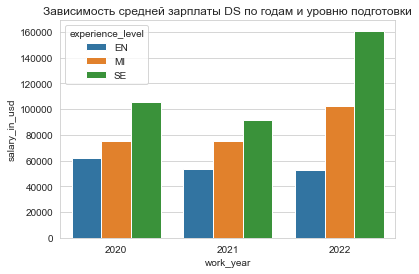

In [710]:
df312=data_ds.groupby(by=['work_year', 'experience_level'], as_index=False)['salary_in_usd'].mean()
fig10=sns.barplot(data=df312, x='work_year', y='salary_in_usd', hue='experience_level') 
fig10.set_title('Зависимость средней зарплаты DS по годам и уровню подготовки')

Можно увидеть, что специалисты уровня EN, пожалуй, свободны от временных изменений. Год 2021 был нелегких для всех, наверняка причиной тому COVID или политические события.
Но сохраняется ли подобная тендеция по странам? Попробуем выяснить

3.3 Зависит ли размер зарплаты от страны работодателя (работника)?

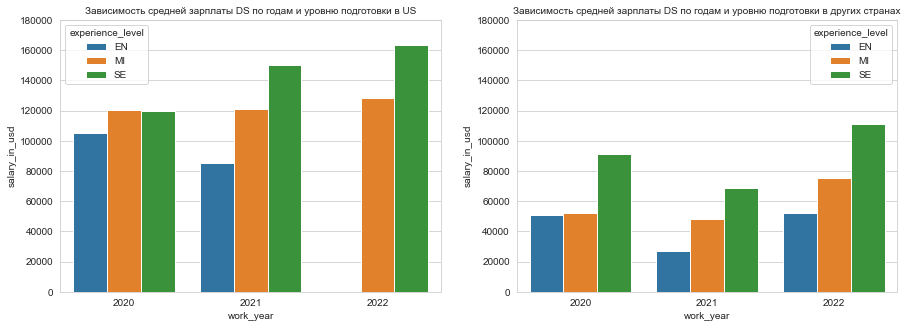

In [711]:
df313=data_ds.groupby(by=['work_year', 'experience_level','country'], as_index=False)['salary_in_usd'].mean()
fig, axes =  plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig11=sns.barplot(data=df313[df313['country']=='US'], x='work_year', y='salary_in_usd', hue='experience_level', ax=axes[0]) 
fig12=sns.barplot(data=df313[df313['country']=='other'], x='work_year', y='salary_in_usd', hue='experience_level', ax=axes[1]) 
axes[0].set_title('Зависимость средней зарплаты DS по годам и уровню подготовки в US',fontsize=10)
axes[1].set_title('Зависимость средней зарплаты DS по годам и уровню подготовки в других странах',fontsize=10)
axes[0].set_yticks(range(0, 200000, 20000)) 
axes[1].set_yticks(range(0, 200000, 20000)) 

Хоть зарплата для уровеня подготовки EN в US в 2022 г. отсуствует, можно с уверенностью предположить, что ее размер выше, чем в других странах, как и зарплаты для остальных уровней подгтовки. 

В 2020 г. в US зарплата у MI и SE отличается не в пользу последних, что является подозрительным. В 2020 г. в других странах зарплата у EN и MI почти не различается, что также является подозрительным. Попробуем оценить значимость подобных результатов с помощью статистических тестов.

Значимость иных результатов анализа, интерпретируемых с помощью графических зависимостей, проверять в данном случае не будем, т.к. они  соответсвуют объективным причинам. Мы сможем вернутсья к этому вопросу при необходимости.

In [712]:
EN_2020_sal=data_ds['salary_in_usd'][(data_ds['country']=='other')&(data_ds['work_year']==2020)&(data_ds['experience_level']=='EN')].to_list()
print('зарплаты EN в 2020 г. в др. странах', EN_2020_sal)
MI_2020_sal=data_ds['salary_in_usd'][(data_ds['country']=='other')&(data_ds['work_year']==2020)&(data_ds['experience_level']=='MI')].to_list()
print('зарплаты MI в 2020 г. в др. странах', MI_2020_sal)

# выборки получились совсем небольшими, однако, я не нашел (как минимум, косвенно) ограничений для таких объемов

# проводим тест Шапиро — Уилка
print('EN p-value:', stats.shapiro(EN_2020_sal)[1])
print('MI p-value:', stats.shapiro(MI_2020_sal)[1]) # обе выборки одновременно не распределены нормально

# две независимые группы, ненормальное распределение - U-критерий Манна-Уитни

# нулевая гипотеза: распределение зарплаты в 2020 г. у EN и MI одинаковое
# альтернативная гипотеза: распределение зарплаты в 2020 г. у EN и MI отличается

p = stats.mannwhitneyu(EN_2020_sal, MI_2020_sal)
print(p)

# p-value больше альфа - нет оснований отвергнуть нулевую гипотезу

зарплаты EN в 2020 г. в др. странах [51321, 39916, 62726, 49268]
зарплаты MI в 2020 г. в др. странах [79833, 35735, 40481, 76958, 38776, 42197]
EN p-value: 0.8686812520027161
MI p-value: 0.017779143527150154
MannwhitneyuResult(statistic=14.0, pvalue=0.7619047619047619)


In [713]:
MI_2020_sal=data_ds['salary_in_usd'][(data_ds['country']=='US')&(data_ds['work_year']==2020)&(data_ds['experience_level']=='MI')].to_list()
print('зарплаты MI в 2020 г. в US', MI_2020_sal)
SE_2020_sal=data_ds['salary_in_usd'][(data_ds['country']=='US')&(data_ds['work_year']==2020)&(data_ds['experience_level']=='SE')].to_list()
print('зарплаты SE в 2020 г. в US', SE_2020_sal)

зарплаты MI в 2020 г. в US [105000, 118000, 138350]
зарплаты SE в 2020 г. в US [120000]


Результат теста показал, что зарплаты  у EN и MI (их распределения) в других странах в 2020 г. не различаются. 

Выборки зарплат для US в 2020 г. для MI и SE получились непригодными для статистического теста, что дает нам моральное право (и не только) оценить их "напрямую": если взять медианну зарплату вместо средней, то рост зарплаты с увеличением уровня подготовки сохраняется.

Здесь имеет место некоторый подгон под ответ, но не без оснований: пограничное состояние, на фоне оценки с точки зрения здравого смысла, было отнесено в пользу именно здравого смысла. 

Учитывая небольшие размеры  выборок и общую тендецию по уровню подготовки, осторожно заментим: размер зарплаты, как правило, растет с повышением уровня квалификации.

3.4 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

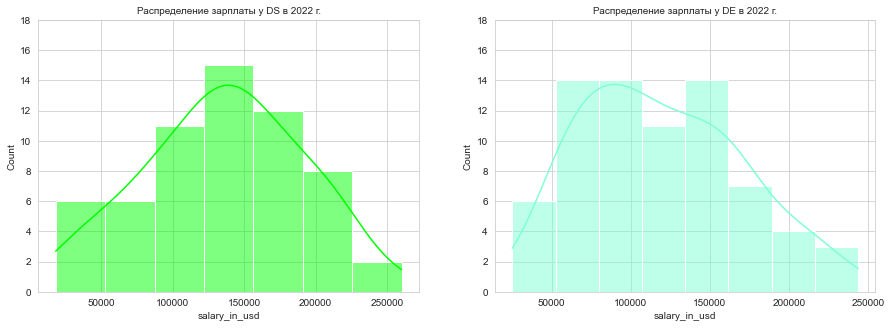

In [714]:
sal_ds_2022=data_ds['salary_in_usd'][data_ds['work_year']==2022]
sal_de_2022=data_de['salary_in_usd'][data_de['work_year']==2022]

sal_ds_2022.mean() # 135848
sal_de_2022.mean() # 119897

fig, axes =  plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig13=sns.histplot(x=sal_ds_2022, color='lime', kde=True, ax=axes[0]) 
fig14=sns.histplot(x=sal_de_2022, color='aquamarine', kde=True, ax=axes[1]) 
axes[0].set_title('Распределение зарплаты у DS в 2022 г.',fontsize=10)
axes[1].set_title('Распределение зарплаты у DE в 2022 г.',fontsize=10)
axes[0].set_yticks(range(0, 20, 2)) 
axes[1].set_yticks(range(0, 20, 2)) 

In [715]:
# проводим тест Шапиро — Уилка
print('DS p-value:', stats.shapiro(sal_ds_2022)[1])
print('DE p-value:', stats.shapiro(sal_de_2022)[1]) # обе выборки распределены нормально

# две независимые группы с нормальным распределением - двухвыборочный Т-критерий

# нулевая гипотеза: средний размер зарплаты в 2022 г. у DS меньше либо равен среднему размеру зарплаты в 2022 г. у DE
# альтернативная гипотеза: средний размер зарплаты в 2022 г. у DS больше среднего размера зарплаты в 2022 г. у DE

# проводим тест Левена на равенство дисперсий
print('равенство дисперсий p-value:',stats.levene(sal_ds_2022, sal_de_2022)[1]) # дисперсии одинаковые

# проводим тест на сравнение средних в группах
print(stats.ttest_ind(sal_ds_2022, sal_de_2022, alternative='greater', equal_var=True))

# p-value меньше альфа - отвергаем нулевую гипотезу

DS p-value: 0.8100998997688293
DE p-value: 0.08788563311100006
равенство дисперсий p-value: 0.6902741885934991
Ttest_indResult(statistic=1.7406616553727459, pvalue=0.04204546196653694)


Средний размер зарплаты у DS в 2022 г. больше среднего размера зарплаты у DE в 2022 г.

3.5 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

Text(0.5, 1.0, 'Зависимость средней зарплаты DS от размера компании')

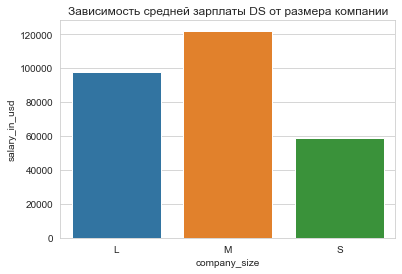

In [716]:
df351=data_ds.groupby(by=['company_size'], as_index=False)['salary_in_usd'].mean()
fig15=sns.barplot(data=df351, x='company_size', y='salary_in_usd',) 
fig15.set_title('Зависимость средней зарплаты DS от размера компании')

In [717]:
s_DS=data_ds['salary_in_usd'][data_ds['company_size']=='S']
m_DS=data_ds['salary_in_usd'][data_ds['company_size']=='M']
l_DS=data_ds['salary_in_usd'][data_ds['company_size']=='L']

s_DS.mean() # 58738
m_DS.mean() # 122046
l_DS.mean() # 97438

# проводим тест Шапиро — Уилка
print('S p-value:', stats.shapiro(s_DS)[1])
print('M p-value:', stats.shapiro(m_DS)[1])
print('L p-value:', stats.shapiro(l_DS)[1]) # все выборки распределены нормально

# три независимые группы с нормальным распределением - однофакторный диспресионный анализ (ANOVA)

# нулевая гипотеза: средний размер зарплаты в компаниях различных размеров одинаков
# альтернативная гипотеза: средний размер зарплаты в компаниях различных размеров различается

# проводим тест Левена на равенство дисперсий
print('равенство дисперсий p-value:',stats.levene(s_DS, m_DS, l_DS)[1]) # дисперсии одинаковые

# проводим тест на сравнение средних в группах
print(stats.f_oneway(s_DS, m_DS, l_DS))

# p-value меньше альфа - отвергаем нулевую гипотезу

S p-value: 0.13523365557193756
M p-value: 0.8448938727378845
L p-value: 0.052294597029685974
равенство дисперсий p-value: 0.11606998807397481
F_onewayResult(statistic=8.59544904862877, pvalue=0.00033506330075091595)


Промежуточный вывод: в компаниях различных размеров различается средний размер зарплаты, в компаниях среднего размера средний размер зарплаты наибольший. 

Проверим, сохраняется ли тендеция в зависимости от уровня подготовки работника?

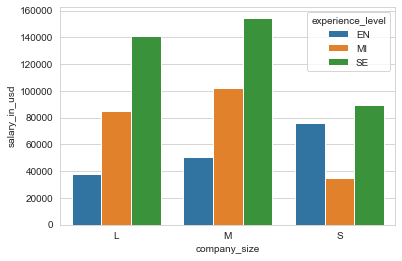

In [718]:
df352=data_ds.groupby(by=['company_size','experience_level'], as_index=False)['salary_in_usd'].mean()
fig16=sns.barplot(data=df352, x='company_size', y='salary_in_usd', hue='experience_level') 

В команиях среднего размера (M) средний размер зарплаты для каждого уровня подготовки работника больше среднего размера зарплаты в крупных компаниях (L) для соответсвенного уровня подготовки работника (прочитать сложно, но смысл, думаю, понятен).

Небольшие компании (S) оставим за скобками: может быть, в некоторых из них работу EN выполняет специалист уровня MI, или вовсе работает один индивидуальный предприниматель, который сам себе EN и SE.

3.6 Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

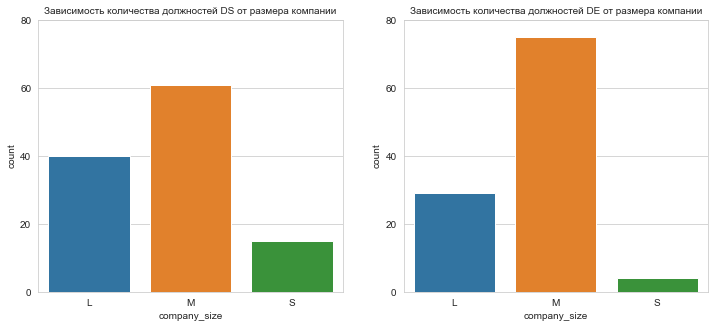

In [729]:
df361=data_ds.groupby(by=['company_size'], as_index=False)['job_title'].count()
df362=data_de.groupby(by=['company_size'], as_index=False)['job_title'].count()

fig, axes =  plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig17=sns.barplot(data=df361, x='company_size', y='job_title', ax=axes[0]) 
fig18=sns.barplot(data=df362, x='company_size', y='job_title', ax=axes[1]) 
axes[0].set_title('Зависимость количества должностей DS от размера компании',fontsize=10)
axes[1].set_title('Зависимость количества должностей DE от размера компании',fontsize=10)
fig17.set_ylabel('count')
fig18.set_ylabel('count')
axes[0].set_yticks(range(0, 100, 20)) 
axes[1].set_yticks(range(0, 100, 20)) 

Исходя из рисунка, можно заключить, что связь между наличием должностей DS и DE и размером компании отсутсвует: наличие должностей DS и DE присутсвует для компаний любого размера.


3.7 Предполагаемый формат работы у DS и DE

Признак remote_ratio мы обошли вниманием. Исправим это с помощью теста для категориальных признаков. Учитывая, что количество DS и DE примерно одинаковое (см. fig5 п. 2.4), попробуем выяснить, есть ли связь между форматом работы и рабочей ролью.

In [753]:
# упростим задачу, классифицируя формат работы на удаленыый и неудаленный 

def remote_ratio_code(arg):
    if arg>0:
        return 'неудаленная'
    else:
        return 'удаленная'

data['remote_ratio_bi']=data['remote_ratio'].apply(remote_ratio_code)

# одна общая выборка (data), оцениваем связь между двумя категориальными переменными - Критерий хи-квадрат

# нулевая гипотеза: признаки рабочей роли и формата работы независимы
# альтернативная гипотеза: признаки рабочей роли и формата работы взаимосвязаны

table1 = pd.crosstab(data['remote_ratio_bi'],data['job_title'])
display(table1)

print('p-value:',stats.chi2_contingency(table1)[1])

# p-value больше альфа - нет оснований отвергать нулевую гипотезу

job_title,Data Engineer,Data Scientist
remote_ratio_bi,,
неудаленная,83,78
удаленная,25,38


p-value: 0.14710082825468032


4. Общие выводы по проекту

4.1 Одназначного ежегодного роста зарплат у DS не наблюдается. Однако, с течением времени зарплата увеличивается.

4.2 Зарплата в US у DS выше, чем в других странах.

4.3 Размер зарплаты, как правило, растет с повышением уровня квалификации.

4.4 Средний размер зарплаты у DS в 2022 г. больше среднего размера зарплаты у DE в 2022 г.

4.5 В компаниях различных размеров различается средний размер зарплаты. 

4.6 В команиях среднего размера (M) средний размер зарплаты для каждого уровня подготовки работника больше среднего размера зарплаты в крупных компаниях (L) для соответсвенного уровня подготовки работника.

4.7 В DS и DE нуждаются компании любого размера.


5. Примечания

5.1 Медианна зарплата на fig1 п. 1.3 почти не отличается у DS и DE. Однако, такой прямой подход недопустим.  

5.2 Дубликаты на первом этапе работы удалять, вероятно, не следовало, т.к. в их наличии нет ничего противоречивого: данные обезличены и могут повторяться.

5.3 Очистка данных произведена "слишком качественно", что, безусловно, сказалось на итоговых выводах. Но, по моему мнению, такой подход обоснован и имеет право на жизнь в контексте поставленных задач.